**Description**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help



**Objective**
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.



**Data Description**
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

# Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist, pdist

import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from yellowbrick.utils.kneed import KneeLocator

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# loading the dataset
data_path = '/content/Credit+Card+Customer+Data.xlsx'
data = pd.read_excel(data_path, sheet_name='Sheet1')

In [ ]:
data.shape

(660, 7)

In [ ]:
# viewing the random sample of the dataset
data.sample(n=10, random_state=10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
254,255,23302,16000,4,3,1,0
349,350,11799,11000,7,3,2,3
295,296,41380,10000,6,4,2,3
35,36,30888,19000,2,0,4,4
377,378,61994,19000,5,2,0,4
484,485,29102,28000,5,4,1,1
257,258,21531,10000,6,4,2,3
78,79,59656,6000,2,0,4,10
386,387,85122,18000,5,2,2,2
285,286,73952,11000,5,5,2,4


In [ ]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [ ]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**We won't need Sl_No and Customer Key for analysis, so let's drop this columns.**

In [ ]:
df.drop(['Sl_No','Customer Key'], axis = 1, inplace=True)

In [ ]:
# let's check the duplicate observation
df.duplicated().sum()

11

* There are 11 duplicate observations. We will remove from the dataset.

In [ ]:
df = df[~df.duplicated()].copy()

In [ ]:
# Let's take a look at the summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


* Average credit limit is 34878.
* All customers having minimul of one credit card and maximum of 10.
* We have customers who never visited the bank, do EDA to find out population.
* We also have customers who never used online banking and visited bank maximum of 15 times, do EDA to find out polulation.
* Average calls are ~ 4 / customers.

In [ ]:
df.loc[df['Total_visits_bank'] == 0]['Total_visits_online'].unique()

array([10, 12,  1, 11,  2,  5,  3,  4, 13, 15,  7,  8,  9])

* Total_visits_online is non negative for those who never visited bank means customers are using online banking mode.  

In [ ]:
df.loc[df['Total_visits_online'] == 0]['Total_visits_bank'].unique()

array([2, 5, 4, 3])

* Total_visits_bank is non negative for those who never used online banking means these customers are using only branch banking.

In [ ]:
# get only numeric columns
num_col = list(df.select_dtypes(include= 'int64').columns)

# EDA

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

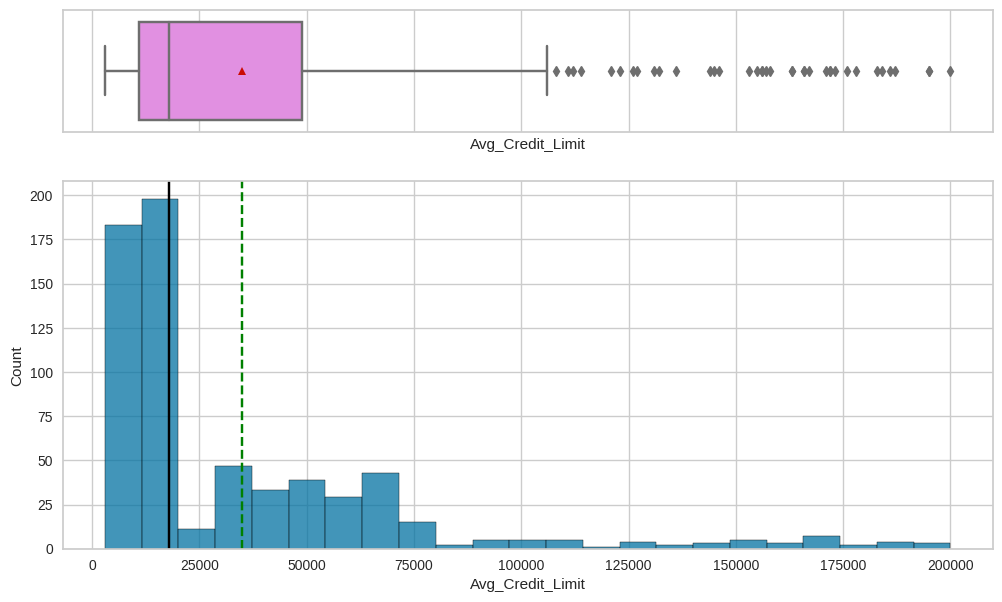

In [ ]:
histogram_boxplot(df,'Avg_Credit_Limit')

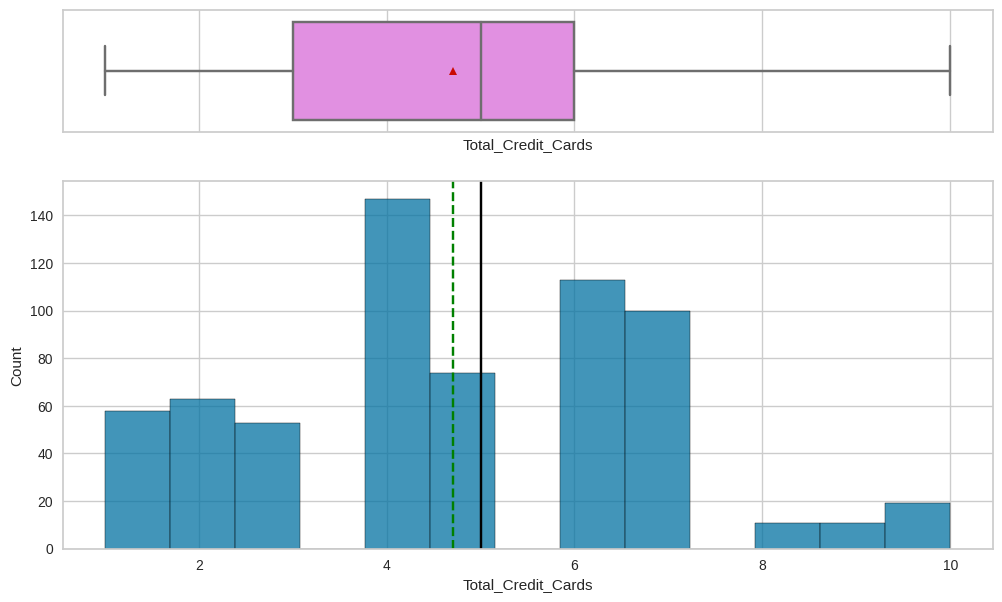

In [ ]:
histogram_boxplot(df,'Total_Credit_Cards')

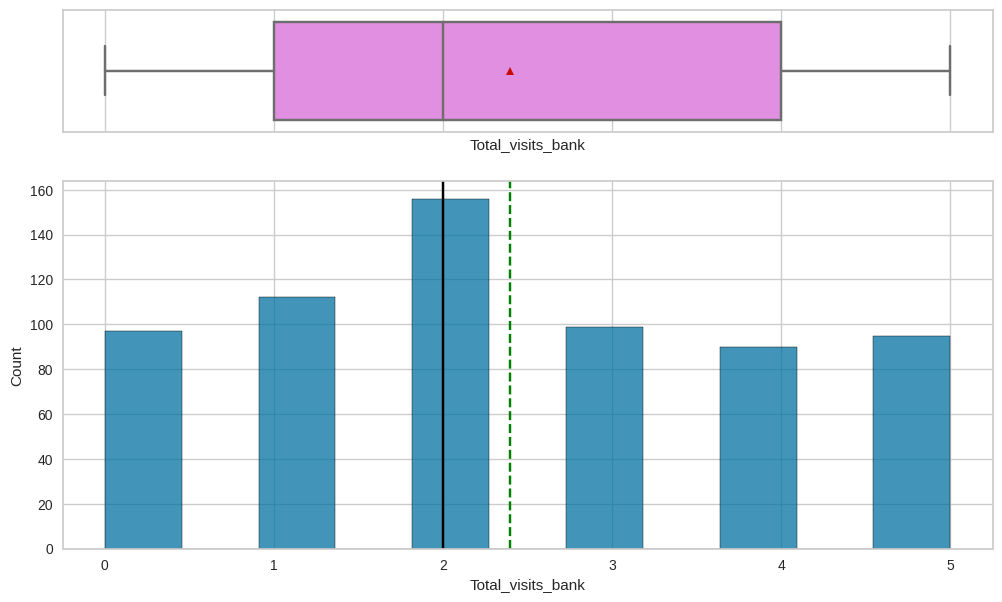

In [ ]:
histogram_boxplot(df,'Total_visits_bank')

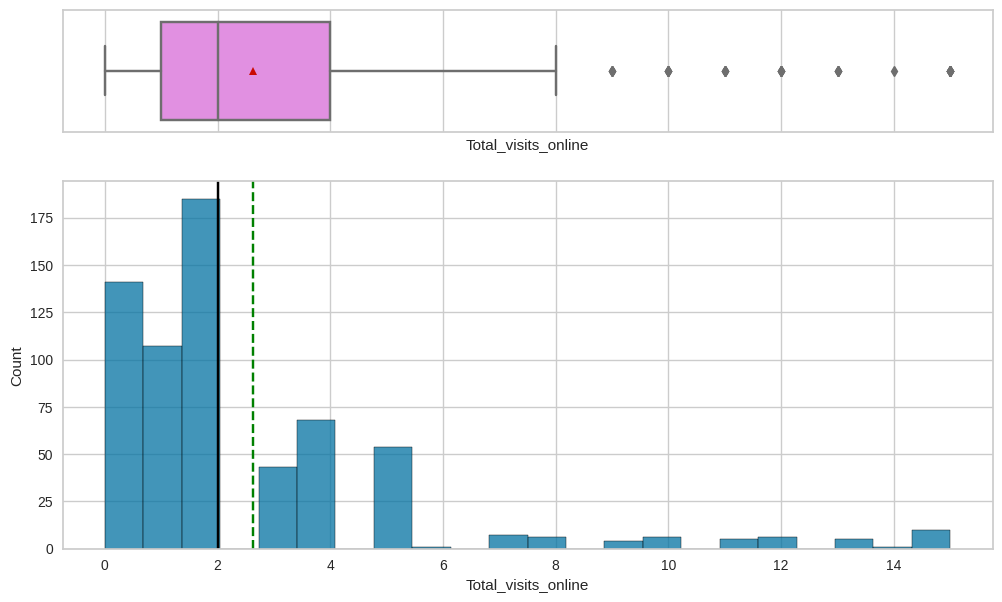

In [ ]:
histogram_boxplot(df,'Total_visits_online')

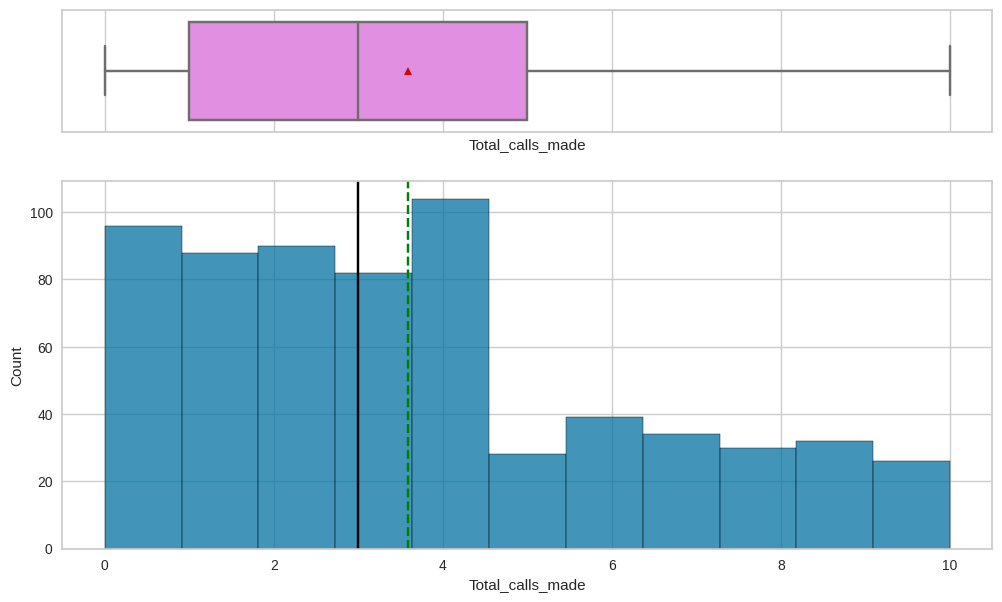

In [ ]:
histogram_boxplot(df, 'Total_calls_made')

* Avg_Credit_Limit has right skewed and maximum customers having average credit limit  < 25000.
* Maximum custmers having 4 credit cards.
* Maximum customers visited the bank and online 2 times.
* Most of the customers made calls 4 times.

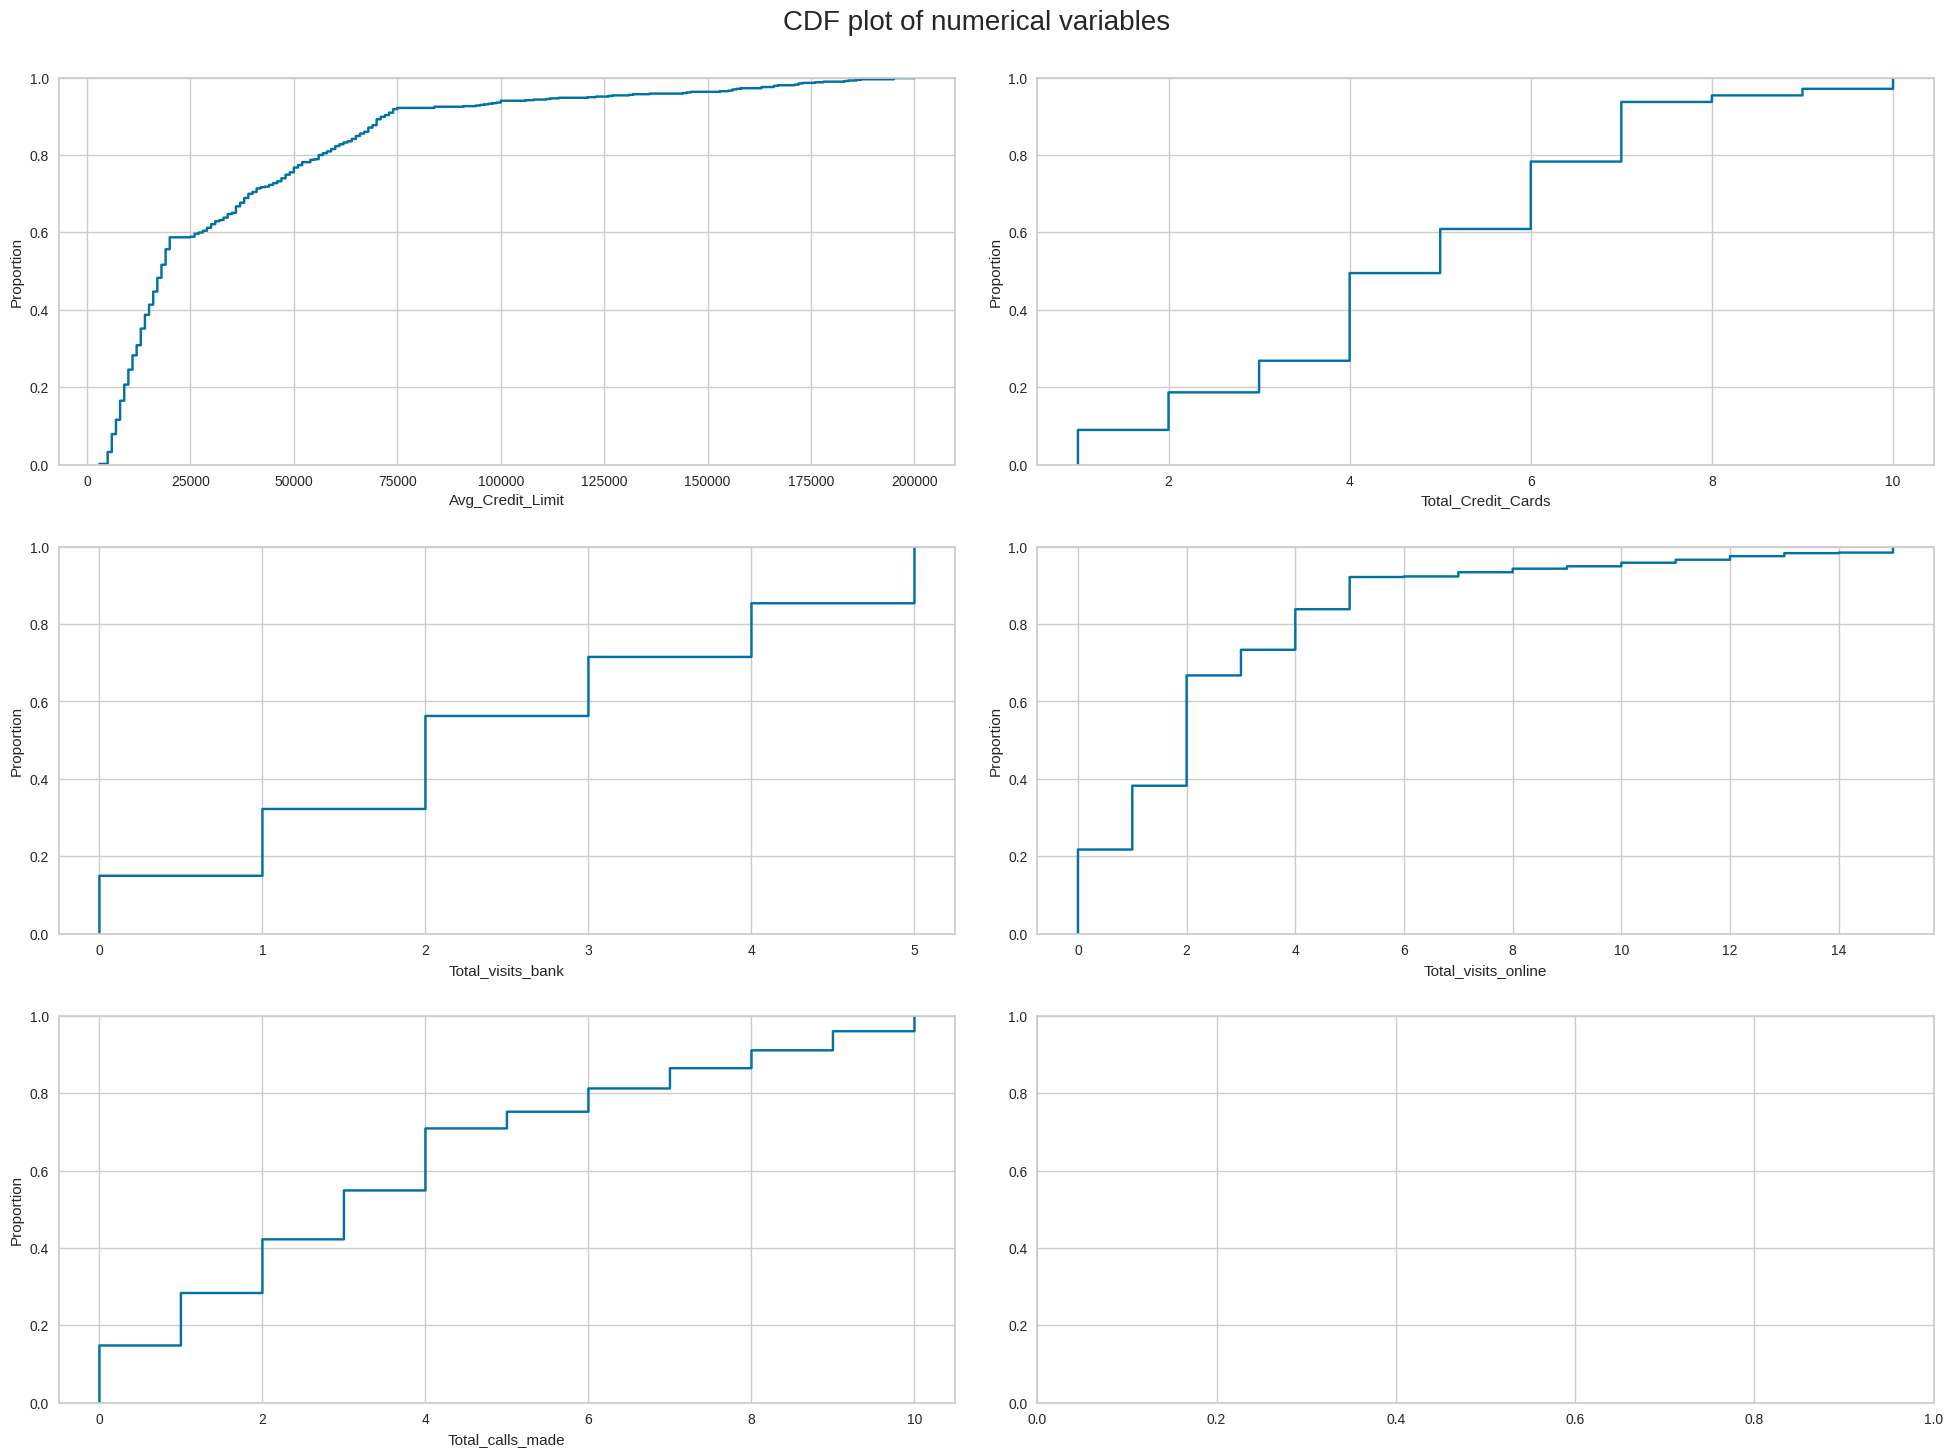

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0

for i in range(3):
  sns.ecdfplot(x=df[num_col[counter]], ax= axes[i][0])
  counter = counter + 1

  if counter != 5:

    sns.ecdfplot(x=df[num_col[counter]], ax=axes[i][1])
    counter = counter + 1
  else:
    pass

fig.tight_layout(pad=2.0)

* 60 % customers having average credit limit 25000.


In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

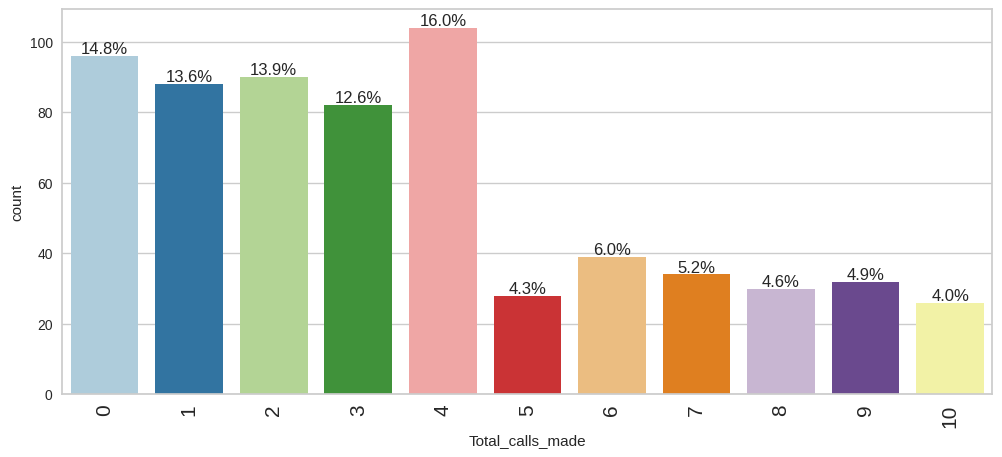

In [ ]:
labeled_barplot(df,'Total_calls_made', perc=True)

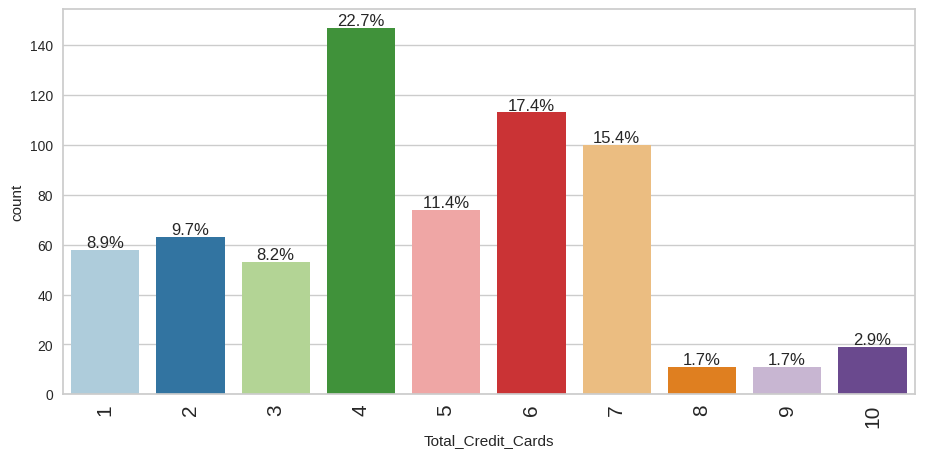

In [ ]:
labeled_barplot(df,'Total_Credit_Cards', perc=True)

* 22.7 % customers having total number of cards are 4.
* 2.9 % customers having total number of cards are 4.
* 4 % customers made 10 calls to customer services.

# Bivariate Analysis

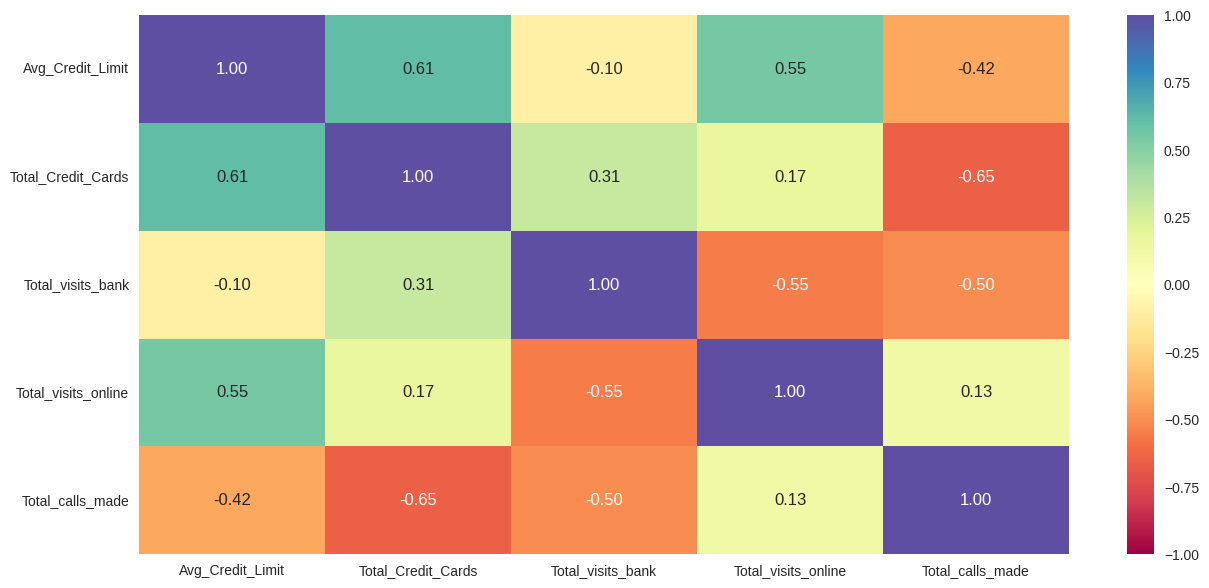

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

* maximum correlation(61%) between Avg_Credit_limit Vs Total_Credit_Cards.
* Total_calls_made is negatively correlated with total_credit_cards means customers not making much calls if they are carring more credit cards.
* Avg_credit_limit Vs total_visits_online is the second largest correclation (55%).
* total_visits_online Vs total_visits_bank is negatively correlated which is obvious.   

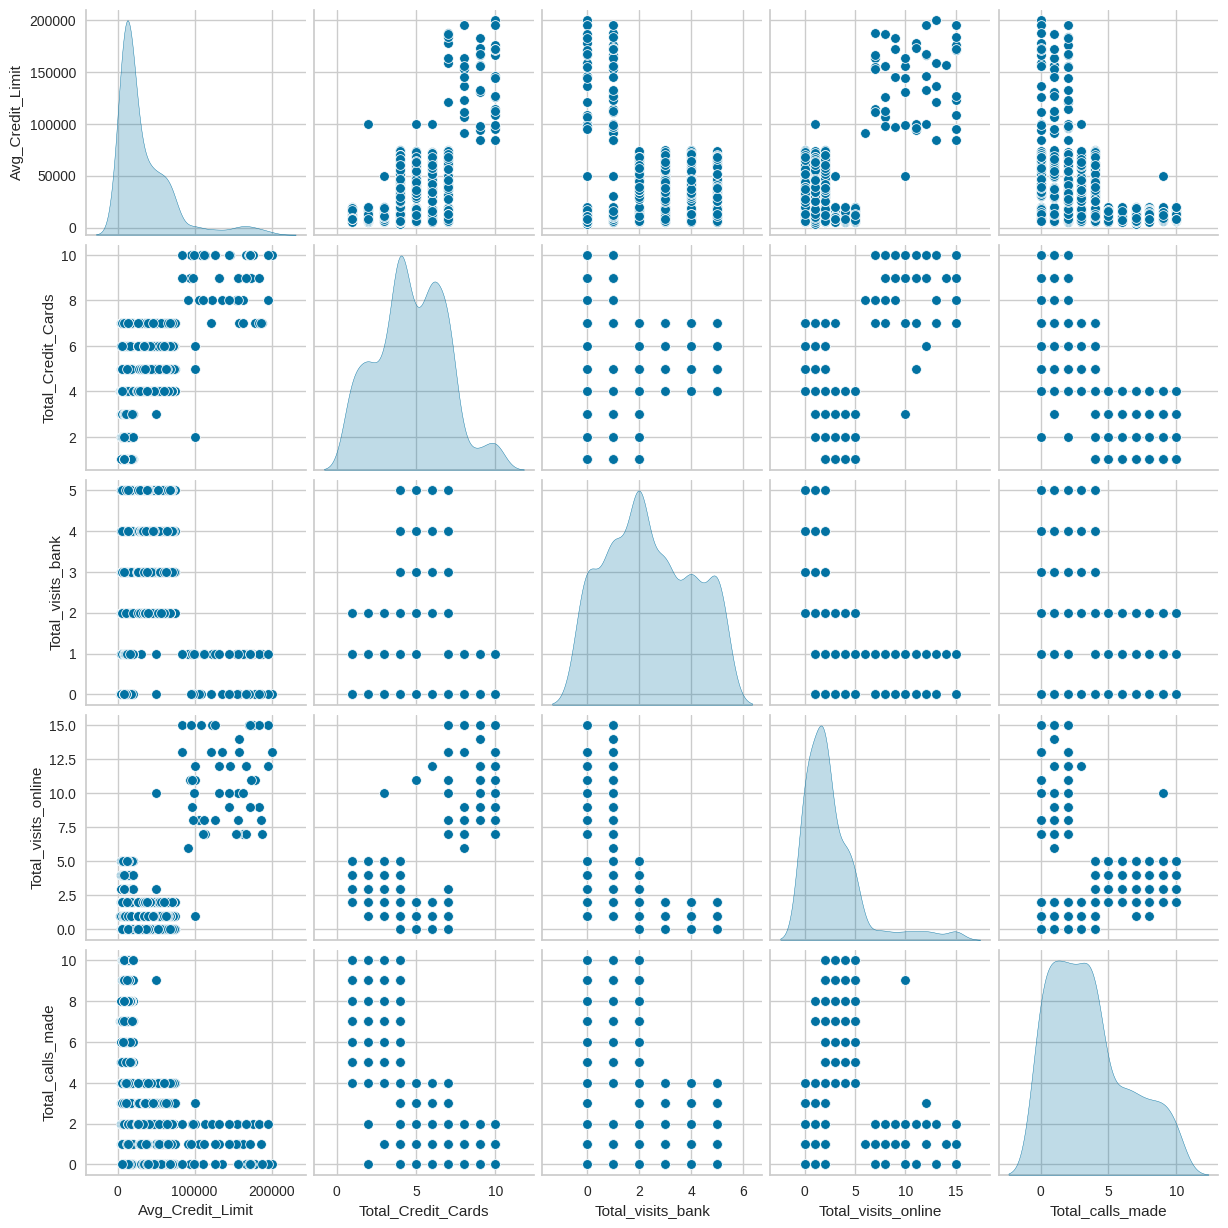

In [ ]:
# draw the pair plot to understand the clustering of the data
sns.pairplot(df[num_col], diag_kind='kde')
plt.show()

* We are getting 2 clusters by looking above pair plots.

# Data Prerocessing

In [ ]:
# scaled the data to avoid any biased
scaler = StandardScaler()
subset = df[num_col]
subset_scaled = scaler.fit_transform(subset)

In [ ]:
# convert the scaled data to pandas data frame
subset_scaled_df = pd.DataFrame(subset_scaled, columns = num_col)


# K-means Clustering

In [ ]:
# declare the KMeans object and fit the scaled data
model_test = KMeans(n_clusters=4)
model_test.fit(subset_scaled_df)
prediction_test = model_test.predict(subset_scaled_df)

In [ ]:
# declare the cluster 1 to 9 and get the distortion
cluster = range(1,10)
meanDistortions = []

for i in cluster:
  model = KMeans(n_clusters=i)
  model.fit(subset_scaled_df)
  prediction = model.predict(subset_scaled_df)

  distortion = sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, metric='euclidean'), axis=1))/subset_scaled_df.shape[0]
  meanDistortions.append(distortion)

  print('Number of cluster: ' , i, '\t Average Distortion: ', distortion)

Number of cluster:  1 	 Average Distortion:  2.007896349270688
Number of cluster:  2 	 Average Distortion:  1.4576197022077821
Number of cluster:  3 	 Average Distortion:  1.1434401208195095
Number of cluster:  4 	 Average Distortion:  1.0435538595477063
Number of cluster:  5 	 Average Distortion:  0.988052836262114
Number of cluster:  6 	 Average Distortion:  0.9404595158514054
Number of cluster:  7 	 Average Distortion:  0.907940468308665
Number of cluster:  8 	 Average Distortion:  0.8908675687471357
Number of cluster:  9 	 Average Distortion:  0.8640822517719562


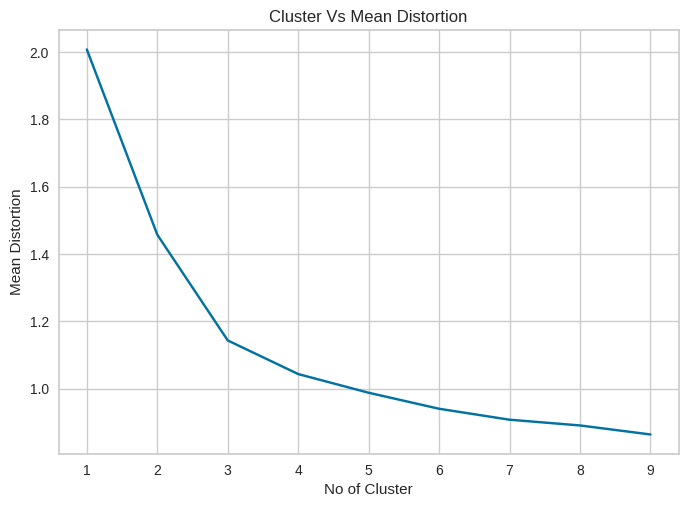

In [ ]:
plt.title('Cluster Vs Mean Distortion')
plt.plot(cluster, meanDistortions, 'bx-')
plt.xlabel('No of Cluster')
plt.ylabel('Mean Distortion')
plt.show()

In [ ]:
#from yellowbrick.utils.kneed import KneeLocator
# find the elbow point
kl = KneeLocator( cluster,meanDistortions,curve_nature='convex', curve_direction='decreasing')
print('K value at:', kl.elbow)

K value at: 3


for cluster: 2 Silhouette score: 0.41800025566689647
for cluster: 3 Silhouette score: 0.516281010855363
for cluster: 4 Silhouette score: 0.3570238219413198
for cluster: 5 Silhouette score: 0.2733171907540546
for cluster: 6 Silhouette score: 0.2565230639576394
for cluster: 7 Silhouette score: 0.24824860896915485
for cluster: 8 Silhouette score: 0.22672964417754565
for cluster: 9 Silhouette score: 0.22719530040214347


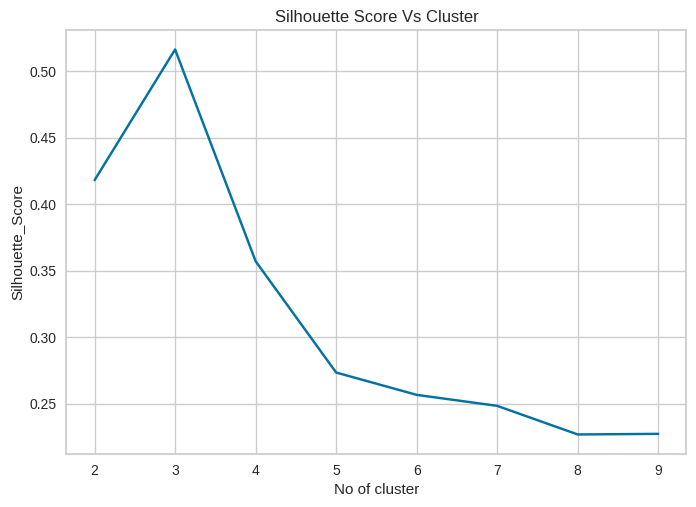

In [ ]:
# Let's check the silhouette scores.
sil_score = []

cluster_list = range(2,10)
for n_cluster in cluster_list:
  cluster_model = KMeans(n_clusters=n_cluster)
  cluster_pred = cluster_model.fit_predict(subset_scaled_df)

  score = silhouette_score(subset_scaled_df,cluster_pred)

  print('for cluster:', n_cluster,'Silhouette score:', score ,)
  sil_score.append(score)

# plot the graph between Silhouette score and cluster
plt.plot(cluster_list, sil_score)
plt.title('Silhouette Score Vs Cluster')
plt.xlabel('No of cluster')
plt.ylabel('Silhouette_Score')
plt.show()


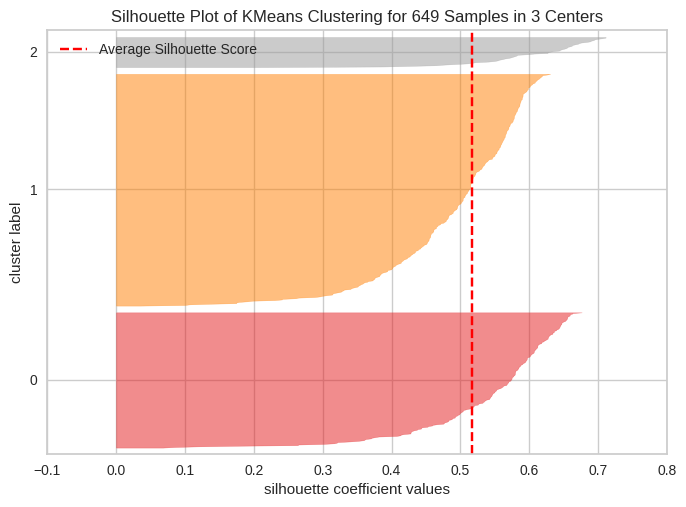

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Silhouette score is high at k = 3
# Consider K = 3 for k means clusterning
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

In [ ]:
df['K_means_segments'] = kmeans.labels_
subset_scaled_df['K_means_segments'] = kmeans.labels_

**Customer Profiling**

In [ ]:
customer_profile = df.groupby('K_means_segments').mean()

In [ ]:
customer_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403
1,34071.428571,5.518519,3.484127,0.981481,1.992063
2,141040.000000,8.740000,0.600000,10.900000,1.080000


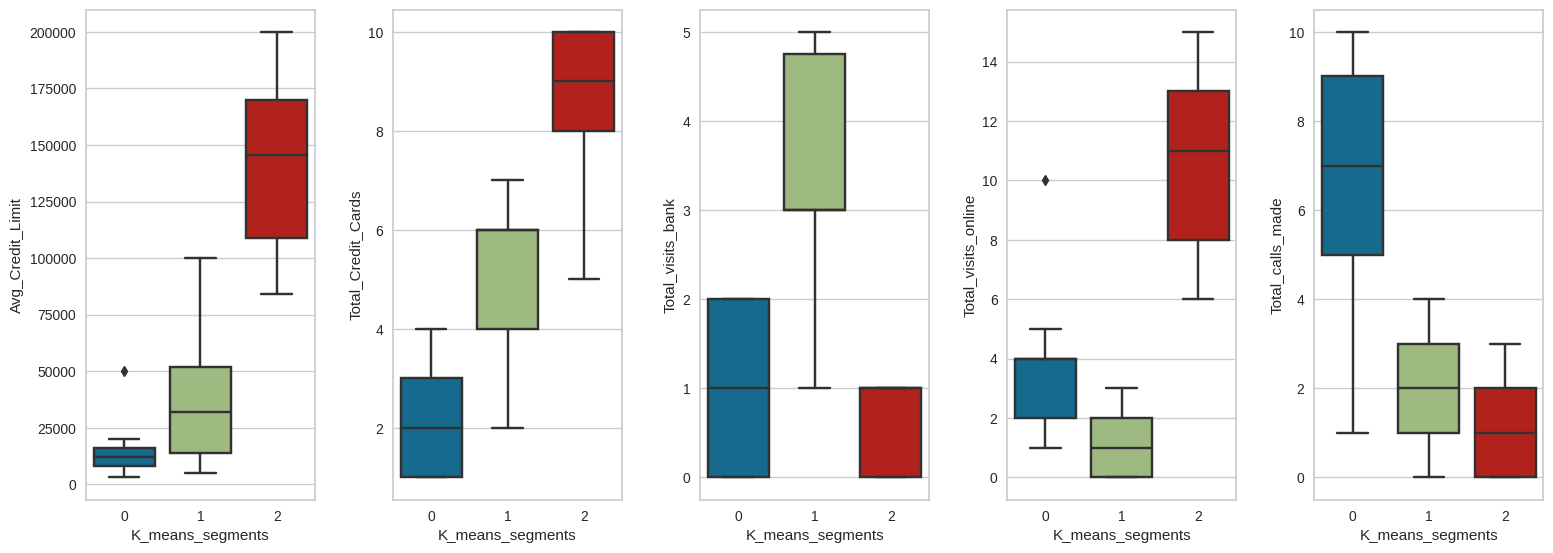

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,6))
for i in range(5):
  sns.boxplot(
      y=df[num_col[i]],
      x=df['K_means_segments'],
      ax=axes[i]
  )
plt.tight_layout(pad=2.0)
plt.show()

**Insights**

* **Cluster 0**
  * This cluster contains the customers having less than 20000 avergae credit limit.
  * Customers carrying credit cards either 1, 2, and 3.
  * Bank visits by these customers are also 0,1 and 2.
  * Online banking by these customers are 2,3 and 4.
  * Total calls made by these cluster's customers are high.
  * These customers come under the average category and need more support from customer service .
  * Educate customers about the online banking and its features.
* **Cluster 1**
  * Credit limit for these customers range 22000 - 50000.
  * Carrying the credit cards by these customers is in the range of 4 to 6.
  * Bank visited by these customers are high and range is 3 to 5.
  * Online banking by customers are low.
  * Total calls made by these customers in the range of 1 to 3 , less than cluster 0 customers.
  * These customers come under the medium category and need less support from customer service comapre to cluster 0 customers.
  * Customer vistited the most in bank . Educate them about the online banking and its feature.
* **Cluster 2**
  * Credit limit for these customers more than 112500.
  * Customers also carrying the maximum number of cards.
  * Very less bank visited.
  * Maximum using the online banking.
  * Minimum calls made by customers.
  * These are consider as wealthy customers and using the online banking the most for bank relatated activities.    




# Cophenetic Correlation

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenetic_corr = 0
high_dm_lm = [0,0]

for dm in distance_metrics:
  for lm in linkage_methods:
    Z = linkage(subset_scaled_df, method=lm, metric=dm)
    coph_corr , coph_distance = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} distance and {} linkage is {}.".format(dm.capitalize(), lm, coph_corr))

    if high_cophenetic_corr < coph_corr:
      high_cophenetic_corr = coph_corr
      high_dm_lm[0] = dm
      high_dm_lm[1] = lm
print('')

Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7379112982920528.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8578617029322211.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960370054789858.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.893309534644998.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7054746377393306.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6165028065519289.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8325710192720918.
Cophenetic cor

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenetic_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [ ]:
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenetic_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
  Z = linkage(subset_scaled_df, method=lm, metric='euclidean')
  coph_corr, coph_distance = cophenet(Z, pdist(subset_scaled_df))

  print("Cophenetic correlation for {} distance and {} linkage is {}.".format('euclidean'.capitalize(), lm, coph_corr))

  if high_cophenetic_corr < coph_corr:
    high_cophenetic_corr = coph_corr
    high_dm_lm[0] = 'euclidean'
    high_dm_lm[1] = coph_corr


Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.894471288720818.
Cophenetic correlation for Euclidean distance and ward linkage is 0.7425813590948763.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.


* **We see the cophenetic correlation is maximum for Euclidean distance and average linkage.**
* **Let's see the dendrograms for the different linkage methods.**

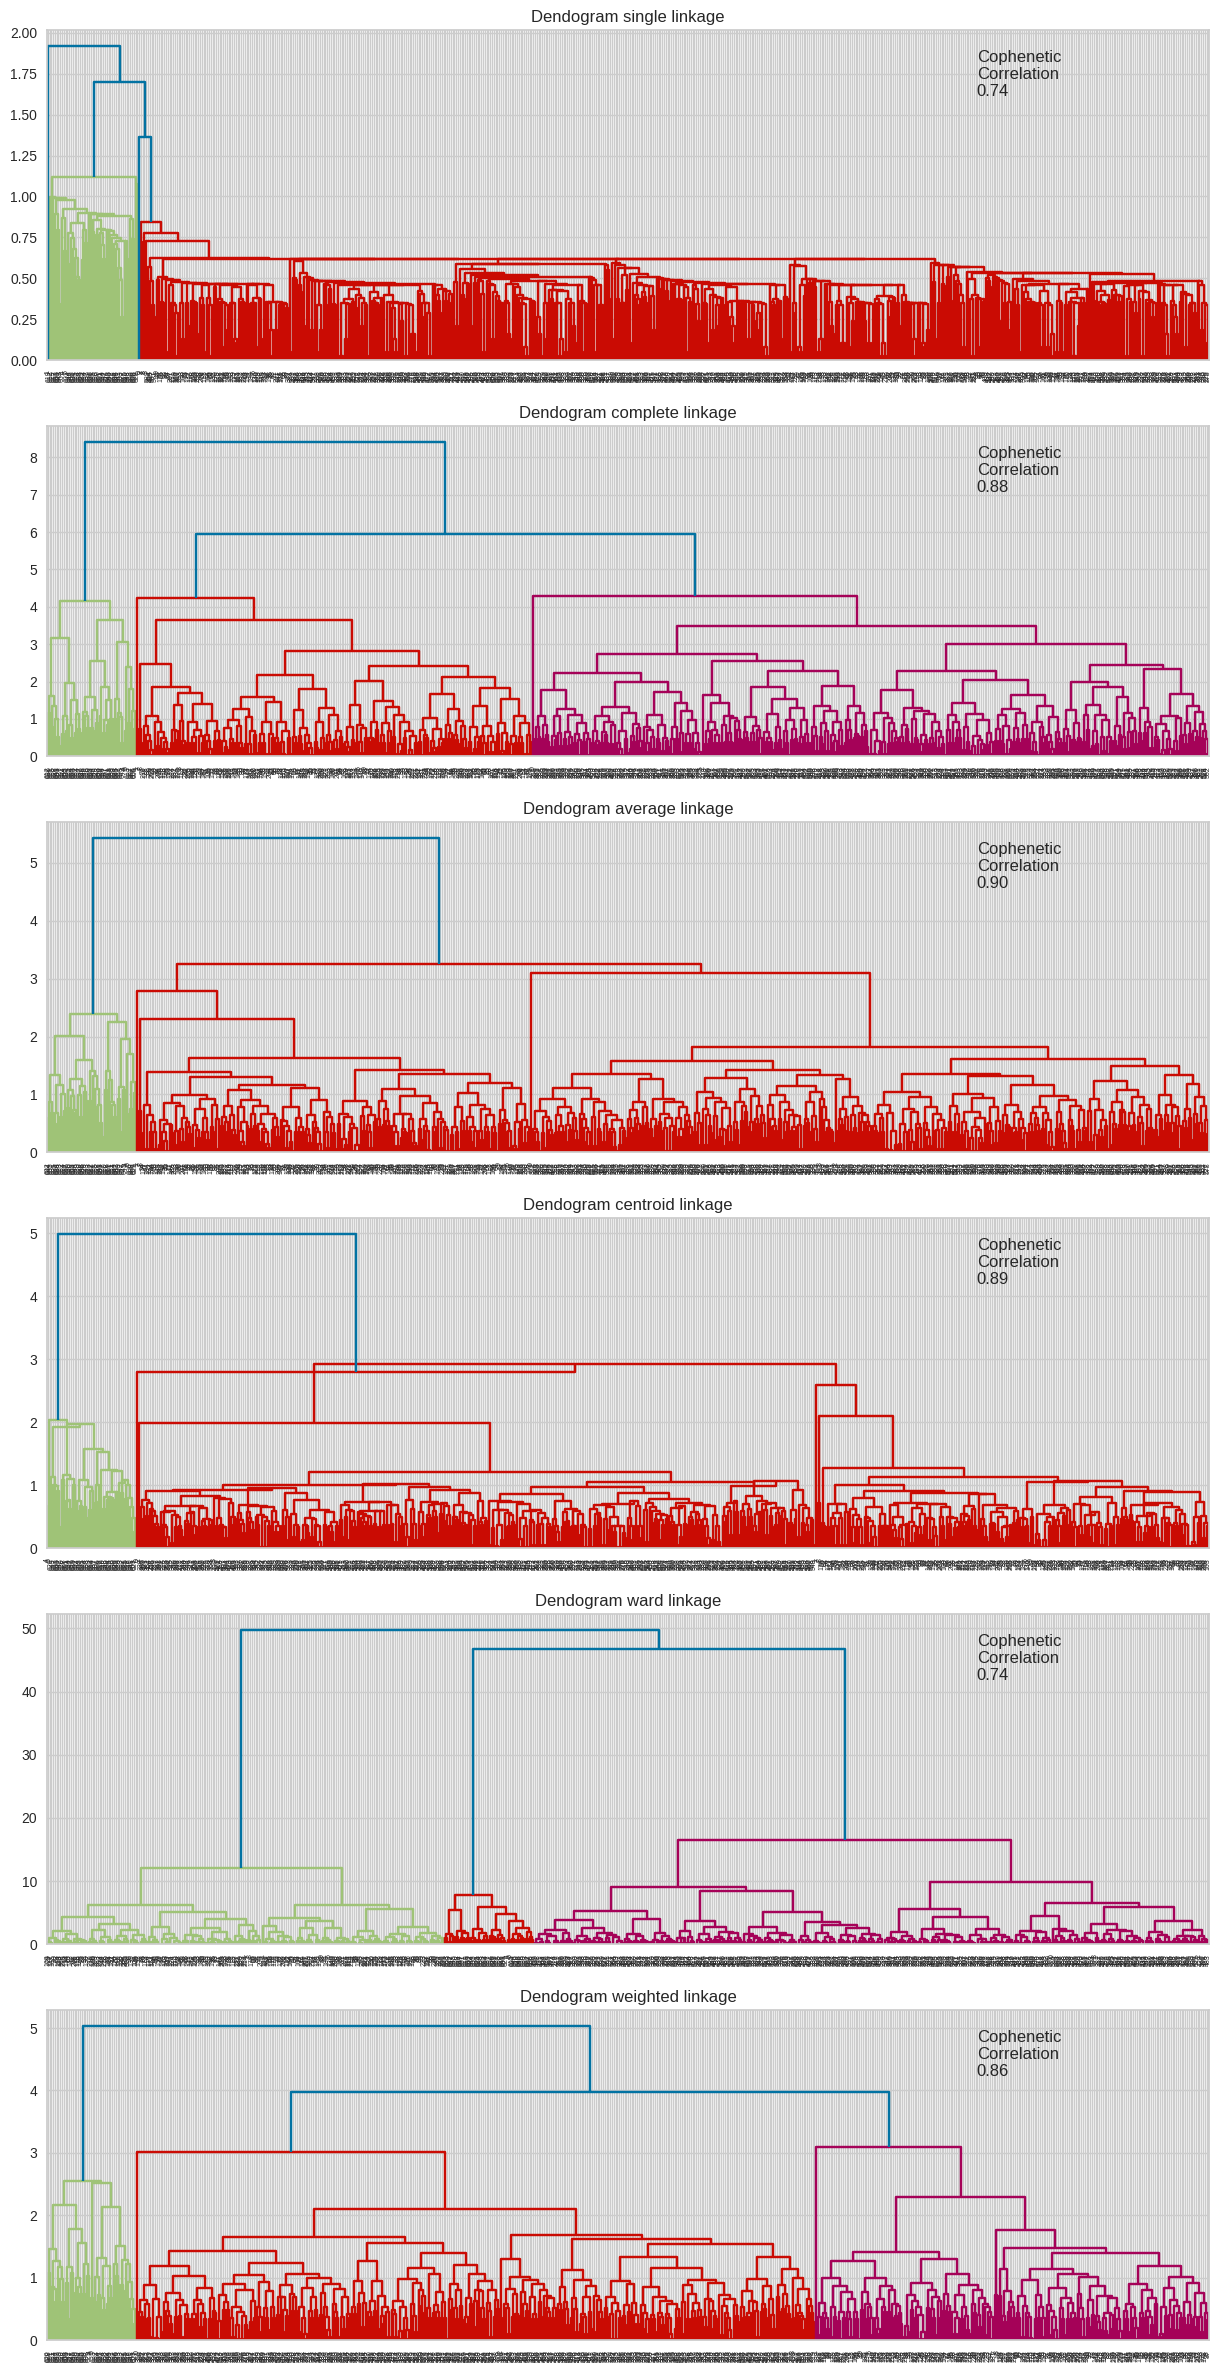

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

fig, axes = plt.subplots(nrows=len(linkage_methods), ncols=1, figsize=(15,30))

for i,lm in enumerate(linkage_methods):
  Z = linkage(subset_scaled_df, method=lm, metric='euclidean')
  dendrogram(Z, ax=axes[i])
  axes[i].set_title(f'Dendogram {lm} linkage')
  coph_corr, coph_distance = cophenet(Z,pdist(subset_scaled_df))
  axes[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction"
  )

* Cophenetic correlation is highest for average and centroid linkage with euclidean distance metric
* For average/centroid linkage method , no of cluster should be 4.
* Lets consider average linkage method and draw the dandogram.

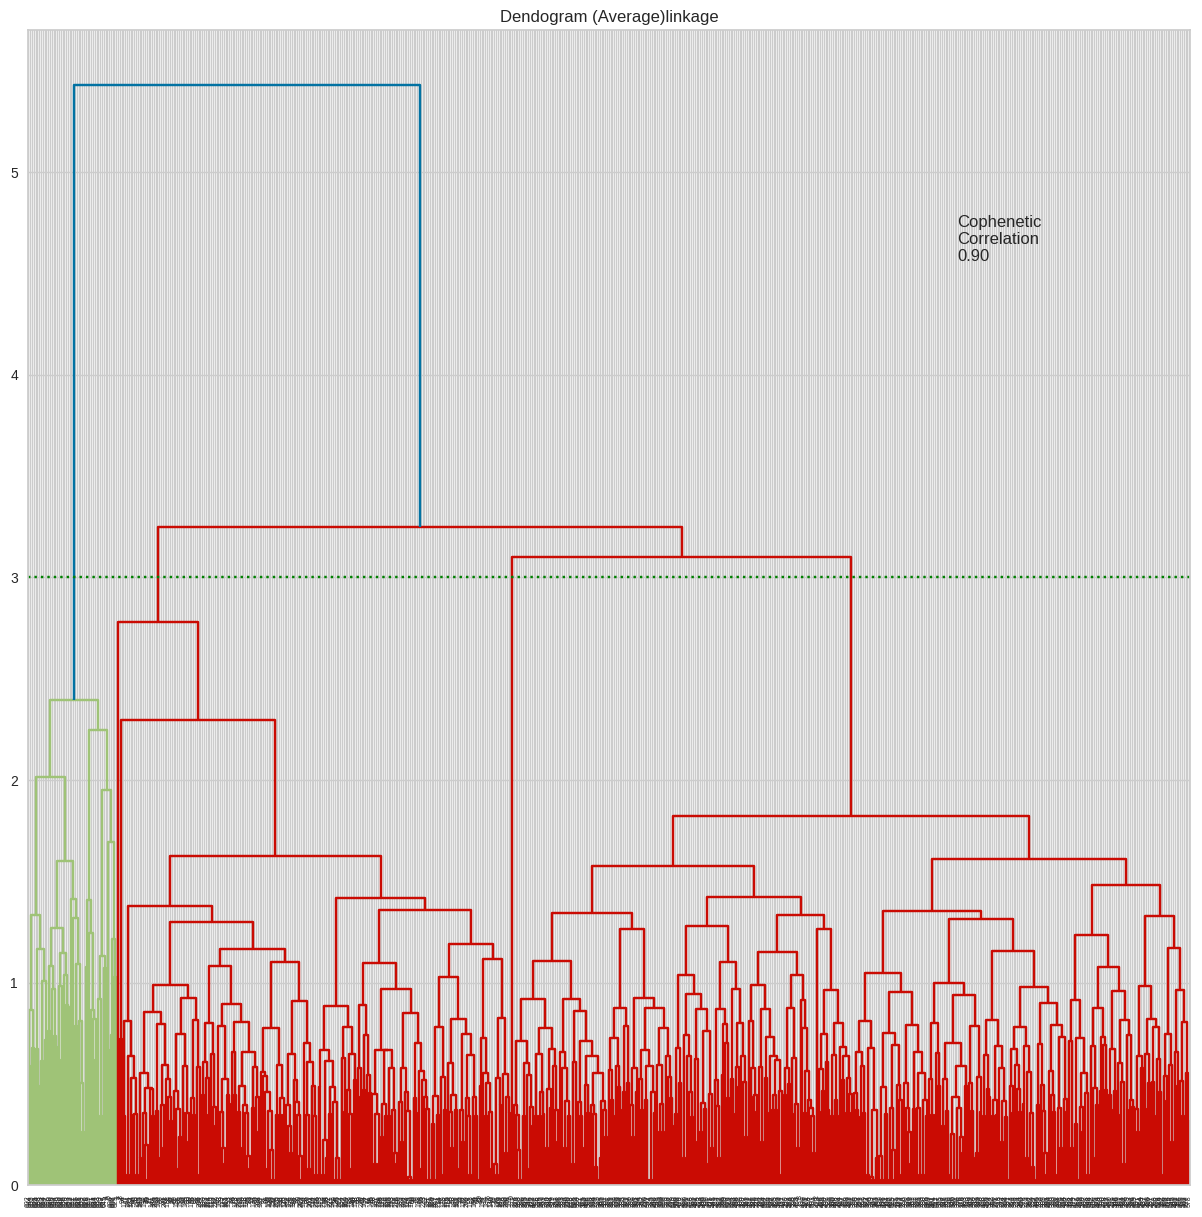

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
Z = linkage(subset_scaled_df, method='average', metric='euclidean')
dendrogram(Z, ax = axes)
axes.set_title(f'Dendogram (Average)linkage')
coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df));
axes.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
plt.axhline(y=3, c= 'green',linestyle="dotted")
plt.show()

# Hierarchical Clustering

In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=4)

In [ ]:
subset_scaled_df['HC_Clusters'] = HCmodel.labels_
df['HC_Clusters'] = HCmodel.labels_

**Customer Profile (HC)**

In [ ]:
customer_profile_hc = df.groupby(['HC_Clusters']).mean()
customer_profile_hc

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_Clusters,,,,,
0,12263.636364,2.404545,0.940909,3.568182,6.904545
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33825.396825,5.523810,3.486772,0.984127,2.002646
3,100000.000000,2.000000,1.000000,1.000000,0.000000


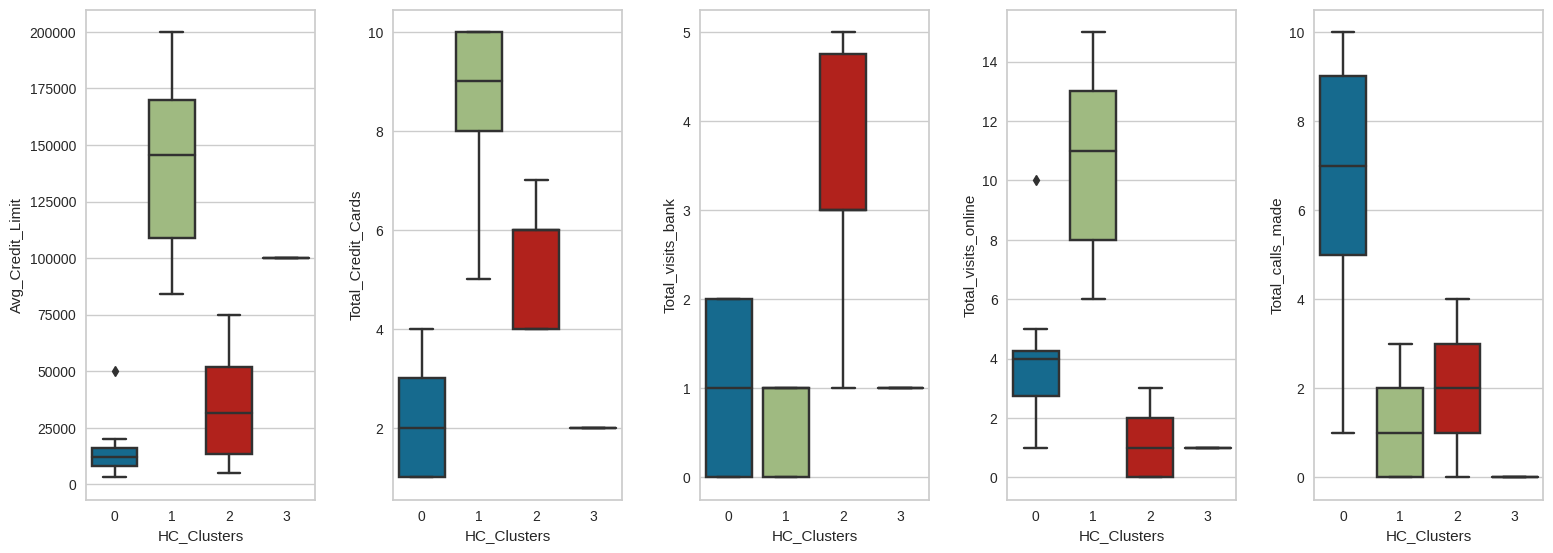

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=5, figsize=(16,6))
for i in range(5):
  sns.boxplot(
      x=df['HC_Clusters'],
      y=df[num_col[i]],
      ax=axes[i]
      )
plt.tight_layout(pad=2.0)
plt.show()


* Cluster 3 contain only 1 customer. hence we should choose 3 clusters to do the customer segmentation.

In [ ]:
# drop the HC_Cluster column to set number of cluster 3
subset_scaled_df.drop('HC_Clusters',axis=1,inplace=True)
df.drop('HC_Clusters',axis=1,inplace=True)

In [ ]:
# Lets create the HC model wih 3 clusters.
HCmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
HCmodel.fit(subset_scaled_df)
HCmodel

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [ ]:
subset_scaled_df['HC_Clusters'] = HCmodel.labels_
df['HC_Clusters'] = HCmodel.labels_

In [ ]:
customer_profile_hc = df.groupby(['HC_Clusters']).mean()
customer_profile_hc

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_Clusters,,,,,
0,34000.000000,5.514512,3.480211,0.984169,1.997361
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12263.636364,2.404545,0.940909,3.568182,6.904545


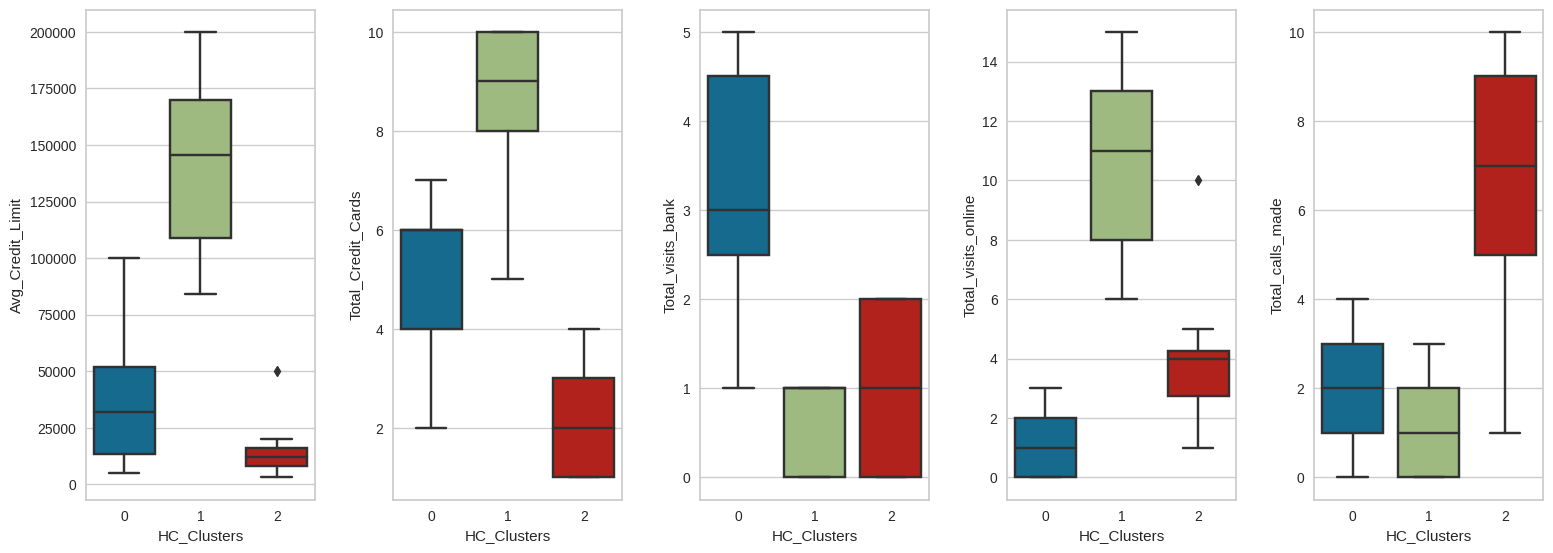

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=5, figsize=(16,6))
for i in range(5):
  sns.boxplot(
      x=df['HC_Clusters'],
      y=df[num_col[i]],
      ax=axes[i]
      )
plt.tight_layout(pad=2.0)
plt.show()

# Dimensionality Reduction using PCA for visualization
  * Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [ ]:
subset_scaled_df.drop('HC_Clusters',axis=1,inplace=True)

In [ ]:
# setting the number of components 3
pca = PCA(n_components=3)

X_reduced_pca = pca.fit_transform(subset_scaled_df)

X_reduced_pca_df = pd.DataFrame(X_reduced_pca, columns=['Component 1', 'Component 2', 'Component 3'])

In [ ]:
X_reduced_pca_df.head()

,Component 1,Component 2,Component 3
0,0.501476,0.508013,1.829151
1,-1.425865,3.103337,-0.900519
2,0.529048,0.809932,0.126358
3,-0.363242,0.127927,0.582337
4,1.296212,3.632136,-0.099553


In [ ]:
# checking the amount of variance explained
pca.explained_variance_ratio_

array([0.45830942, 0.37437508, 0.06362143])

In [ ]:
# total variance of data
pca.explained_variance_ratio_.sum()

0.8963059302517935

* First two components explained 83.26 % of the variance of data.
* All three components explained 89.63 %  of the variance of data.

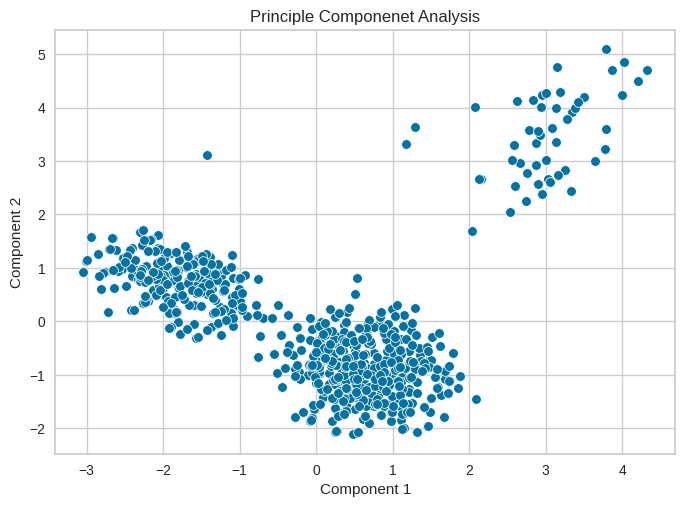

In [ ]:
sns.scatterplot(X_reduced_pca_df,x='Component 1',y='Component 2')
plt.title('Principle Componenet Analysis')
plt.show();

* We can clearly see two broad clusters and another cluster which are far from the others which represent the customers having larger credit limit hence not a true outlier.

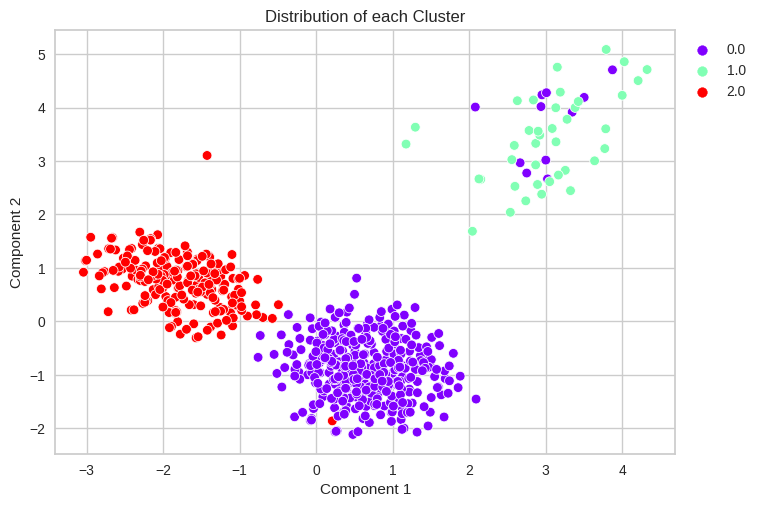

In [ ]:
sns.scatterplot(
    X_reduced_pca_df,
    x = 'Component 1',
    y = 'Component 2',
    hue = df['HC_Clusters'],
    palette='rainbow'
)
plt.title('Distribution of each Cluster')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# K-means vs Hierarchical Clustering
* Both clustering giving the 3 number of clusters to segment the customers and based on average credit limit.
* number of Cluster 3 are good places to provide customer services based on cluster profiling done above.
* K means and Hierarchical clustering are segmenting the customers based on average credit limit.

# Recommendations
* Customers are segmented in three categories based on average credit limit:
  * Average ( < 25000)
  * Medium Average ( > 22000 < 50000)
  * Wealthy (> 100000)  
* Bank required to focus of Average and Medium Average category customers because of getting more calls from these categories to resolve the queries for better customer service model.
* Bank require to educate Average and medium average categories customers about the benefits of online banking.   